<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow prat 3: Scaling up

We'll be scaling up to all 101 classes of food.

Our goal is to outperform the original Food101 paper (50.76%) with 10% of training data

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [2]:
!nvidia-smi

Thu Oct 26 16:39:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created series of helper functions. Now we're going to import them

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-26 16:42:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-26 16:42:01 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions into our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

10% of the training data, let's download it.

In [7]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip") # without .zip produces error

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-10-26 16:50:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  41.0MB/s    in 40s     

2023-10-26 16:51:29 (39.2 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [8]:
# How many images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes dataset

StepsŁ
1. Setup a model checkpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless Functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs and validate on 15% of the test data


In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [15]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation as a layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
    # preprocessing.Rescale(1./255.) #when using EfficientNet not needed
], name="data_augmentation")

In [17]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable output layer
inputs = layers.Input(shape=(224, 224, 3), name="input")
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # in inference mode - stays frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names),
                       activation="softmax",
                       name="output")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [18]:
# Get the summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output (Dense)              (None, 101)               129381    
                                                             

In [19]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [21]:
# Fit
history_1 = model.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("experiments","10_percent_data"), checkpoint_callback])

Saving TensorBoard log files to: experiments/10_percent_data/20231026-173305
Epoch 1/5
237/237 [==============================] - 55s 228ms/step - loss: 3.1319 - accuracy: 0.3175 - val_loss: 2.4620 - val_accuracy: 0.4566
Epoch 2/5
237/237 [==============================] - 45s 186ms/step - loss: 2.1454 - accuracy: 0.5098 - val_loss: 2.0647 - val_accuracy: 0.5048
Epoch 3/5
237/237 [==============================] - 42s 174ms/step - loss: 1.7888 - accuracy: 0.5749 - val_loss: 1.9402 - val_accuracy: 0.5077
Epoch 4/5
237/237 [==============================] - 50s 207ms/step - loss: 1.5879 - accuracy: 0.6071 - val_loss: 1.8917 - val_accuracy: 0.5127
Epoch 5/5
237/237 [==============================] - 37s 154ms/step - loss: 1.4440 - accuracy: 0.6450 - val_loss: 1.8405 - val_accuracy: 0.5169


In [22]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 63s 79ms/step - loss: 1.5813 - accuracy: 0.5827


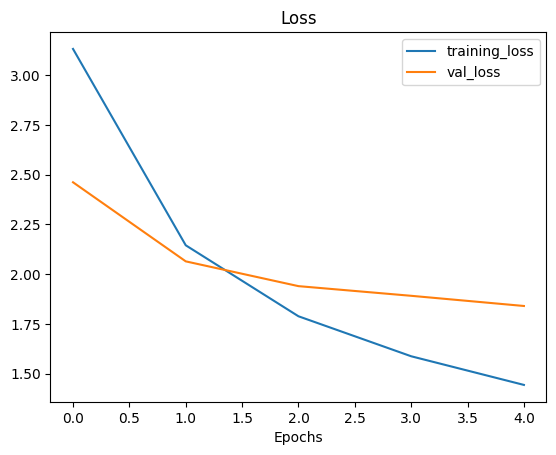

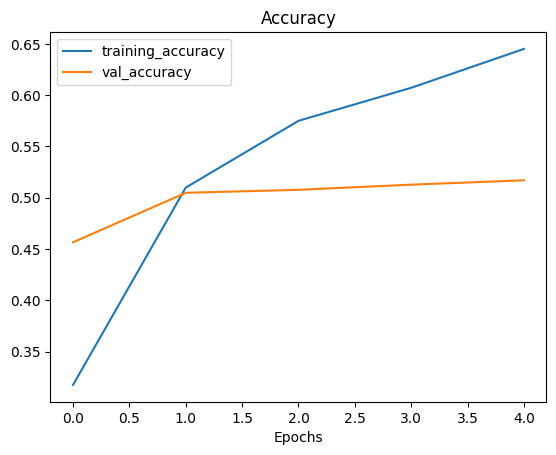

In [23]:
plot_loss_curves(history_1)

Overfitting HA!